# Gyral sulcal differences map

In [1]:
%cd work/notebooks

/home/jovyan/work/notebooks


In [2]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from mri_maps import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/plot_maps.R");

In [4]:
# dm_hcp_ds8 = gradientVersion().fit('hcp_ds8')
# scores_ds8 = dm_hcp_ds8.clean_scores()

dm_hcp_3d_ds5 = gradientVersion().fit('hcp_3donors_ds5')
scores_ds5 = dm_hcp_3d_ds5.clean_scores()

New gradients version: method=dm, params={'alpha': 1}, kernel=normalized_angle, sparsity=0, data=hcp_3donors_ds5


In [5]:
# hcp_scores = pd.concat({'DS8': scores_ds8, '3+ DS5': scores_ds5}).reset_index(0).rename({'level_0':'version'}, axis=1)

In [6]:
# Load gyral sulcal diff data
import nibabel as nib
scz_diff_img = nib.load('../data/lh.GyralSulcalDifferences.mgh')

In [7]:
# Parcellate and label
from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels

hcp_img_path = '../data/parcellations/lh.HCPMMP1.annot'
hcp_img = annot_to_gifti(hcp_img_path)

scz_diff_hcp = vertices_to_parcels(scz_diff_img.get_fdata(), hcp_img)

In [8]:
from neuromaps.images import annot_to_gifti
from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels

hcp_img = annot_to_gifti("../data/parcellations/lh.HCPMMP1.annot")
dk_img = annot_to_gifti("../data/parcellations/lh.aparc.annot")

# Use HCP parcellation image to project HCP data to fsaverage
g_fsaverage = parcels_to_vertices(scz_diff_hcp, hcp_img)
# Use DK parcellation image to project fsaverage data into DK
g_dk = vertices_to_parcels(g_fsaverage, dk_img)

In [9]:
scz_diff_dk = pd.DataFrame({'scz_diff':g_dk}, index=get_labels_dk()[:34])
scz_diff_dk
get_disorder_maps().join(scz_diff_dk).corr()

scz_diff_volume_scatter = get_disorder_maps()[['SCZ']].join(scz_diff_dk)

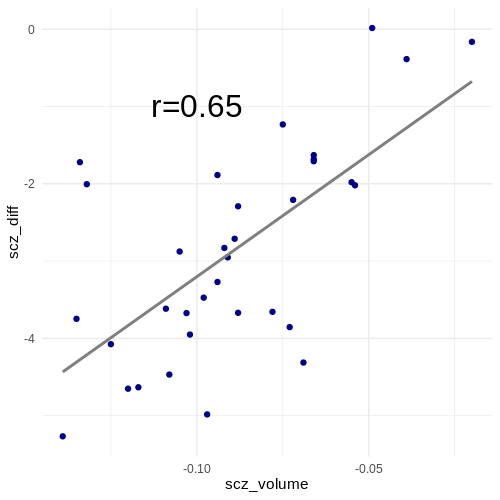

In [10]:
%%R -i scz_diff_volume_scatter -w 5 -h 5 --units in -r 100
scz_diff_volume_scatter %>%
rename(scz_volume = SCZ) %>%
ggplot(aes(scz_volume, scz_diff)) + 
geom_point(color='darkblue') + 
geom_smooth(method='lm', color='grey50', se=F) +
annotate(x=-.1,y=-1,label='r=0.65', geom='text', size=8) +
theme_minimal()

In [11]:
scz_diff = get_labels_hcp()[:180].to_frame().assign(SCZ_supergranular = scz_diff_hcp).set_index('label')
# scz_diff = scz_diff.assign(scz_diff_norm = lambda x: x[['scz_diff']].apply(lambda y: (y-np.mean(y))/np.std(y)))
# scz_diff

In [12]:
scz_diff_scatter = scz_diff \
    .join(scores_ds5.set_index('label')).reset_index() \
    .melt(id_vars=['label','SCZ_supergranular'], var_name='G', value_name='G_score') \
    .rename({'SCZ_supergranular':'map_score'}, axis=1).assign(map='SCZ_supergranular')
# scz_diff_scatter

In [13]:
# nulls = np.load('../outputs/permutations/hcp_ds8_spin_1000.npy')
nulls = np.load('../outputs/permutations/hcp_3d_ds5_spin_1000.npy')
null_corrs = corr_nulls_from_grads(nulls, scores_ds5, scz_diff)

In [14]:
scz_diff_corrs = null_corrs.reset_index().rename({'level_0':'G', 'level_1':'map'}, axis=1)
scz_diff_corrs

,G,map,r,p,q
0,G1,SCZ_supergranular,-0.130684,0.778222,0.778222
1,G2,SCZ_supergranular,0.148475,0.742258,0.778222
2,G3,SCZ_supergranular,0.552219,0.002997,0.008991


In [15]:
scores_ds5_dk = dm_hcp_3d_ds5.score_in_dk()

In [16]:
brainchart_scz = get_disorder_maps()[['SCZ']].rename({'SCZ':'SCZ volume'}, axis=1)

brainchart_scz_scatter = brainchart_scz \
    .join(scores_ds5_dk.set_index('label')).reset_index() \
    .melt(id_vars=['label','SCZ volume'], var_name='G', value_name='G_score') \
    .rename({'SCZ volume':'map_score'}, axis=1).assign(map='SCZ volume')
brainchart_scz_scatter

,label,map_score,G,G_score,map
0,lh_bankssts,-0.078,G1,0.140624,SCZ volume
1,lh_caudalanteriorcingulate,-0.049,G1,-1.093290,SCZ volume
2,lh_caudalmiddlefrontal,-0.088,G1,0.149750,SCZ volume
3,lh_cuneus,-0.066,G1,1.848705,SCZ volume
4,lh_entorhinal,-0.055,G1,-1.473872,SCZ volume
...,...,...,...,...,...
97,lh_supramarginal,-0.125,G3,-1.371250,SCZ volume
98,lh_frontalpole,-0.088,G3,-0.470090,SCZ volume
99,lh_temporalpole,-0.091,G3,0.696347,SCZ volume
100,lh_transversetemporal,-0.117,G3,0.985056,SCZ volume


In [17]:
nulls = np.load('../outputs/permutations/hcp_3d_ds5_spin_5000_in_dk.npy')[:,:,:1000]
null_corrs = corr_nulls_from_grads(nulls, scores_ds5_dk, brainchart_scz)
brainchart_scz_corrs = null_corrs.reset_index().rename({'level_0':'G', 'level_1':'map'}, axis=1)
brainchart_scz_corrs

FileNotFoundError: No such file or no access: '[-1.40441795  1.42818514 -0.10113554  1.30811898  1.9565321  -0.85273041
 -1.28000638 -1.08775981 -0.12751834  0.6567171  -0.92563134  1.04978405
 -0.52647211 -0.87836021  1.07951936  0.96749712 -0.77832789 -1.28334508
 -1.19605067  1.70713896  0.7981626   0.02310506  1.38988264 -0.59267989
  0.66691446 -1.12730839  0.03336787 -0.21424677 -0.68631567 -1.37124996
 -0.47009005  0.69634706  0.98505627  0.1573177 ]'

In [ ]:
%%R -w 20 -h 14 --units in -r 100 -i scores_ds5 -i scz_diff -i scz_diff_scatter -i scz_diff_corrs -i brainchart_scz -i brainchart_scz_scatter -i brainchart_scz_corrs
source("../code/brainPlots.R")
source("../code/plot_maps.R")

g0 = plot_hcp_wide(scores_ds5) + ggtitle('AHBA gradients filtering for most stable regions (137/180) and genes (top 50%, ~8k)')
g1 = plot_maps_dk(brainchart_scz, name='mean centile score of cortical volume') #+ theme(legend.position='right')
g2 = plot_maps(scz_diff, name='case-control Z of gyral vs sulcal thickness') #+ theme(legend.position='right')
g1b = plot_maps_scatter(brainchart_scz_scatter, brainchart_scz_corrs) + plot_layout(tag_level='new')
g2b = plot_maps_scatter(scz_diff_scatter, scz_diff_corrs, y=2) + plot_layout(tag_level='new')

plot = (
g0 / (g1 | g1b) / (g2 | g2b)
) 
themed = plot & theme(
    strip.text=element_text(size=22), 
    legend.title=element_text(size=20), 
    legend.text=element_text(size=20), 
    strip.text.y.left=element_text(angle=90),
    plot.tag.position = c(0, 1),
    plot.tag = element_text(size=28, face='bold', hjust=0)
    )

themed + plot_annotation(tag_level='a')

UsageError: Cell magic `%%R` not found.


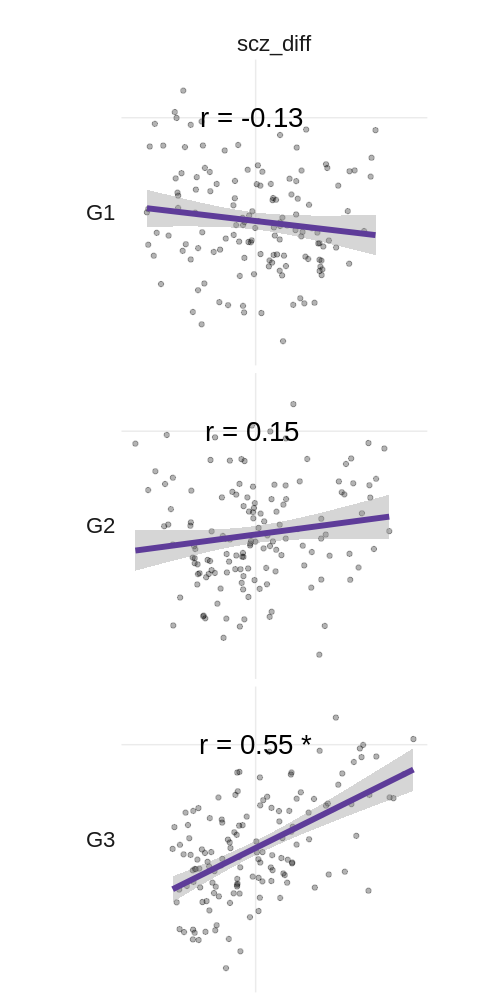

In [ ]:
%%R -w 5 -h 10 --units in -r 100 -i scz_diff -i hcp_scores -i scz_diff_scatter -i scz_diff_null_p
g3 = plot_maps_scatter(scz_diff_scatter, scz_diff_null_p, size=7, facet='h')
g3 & theme(text=element_text(size=16))

In [13]:
nulls_ds8 = {
    'ds8_sim_5000': np.load("../outputs/permutations/hcp_ds8_sim_5000.npy"),
    'ds8_spin_5000': np.load("../outputs/permutations/hcp_ds8_spin_5000.npy")
}

nulls_ds5 = {
    'ds5_sim_5000': np.load("../outputs/permutations/hcp_3d_ds5_sim_5000.npy"),
    'ds5_spin_5000': np.load("../outputs/permutations/hcp_3d_ds5_spin_5000.npy")
}

In [14]:
null_corrs_dict_ds8 = {name: corr_nulls_from_grads(nulls[:,:,:], scores_ds8, scz_diff) for name, nulls in nulls_ds8.items()}
null_corrs_dict_ds5 = {name: corr_nulls_from_grads(nulls[:,:,:], scores_ds5, scz_diff) for name, nulls in nulls_ds5.items()}

In [15]:
null_corrs_dict = {**null_corrs_dict_ds8, **null_corrs_dict_ds5}
corr_versions = {version:stats for version, stats in null_corrs_dict.items()}
corr_versions = pd.concat(corr_versions).reset_index().set_axis(['version','G','map','r','p','q'], axis=1)

In [17]:
save_pickle(corr_versions, 'corr_versions_scz_gyral_sulcal')

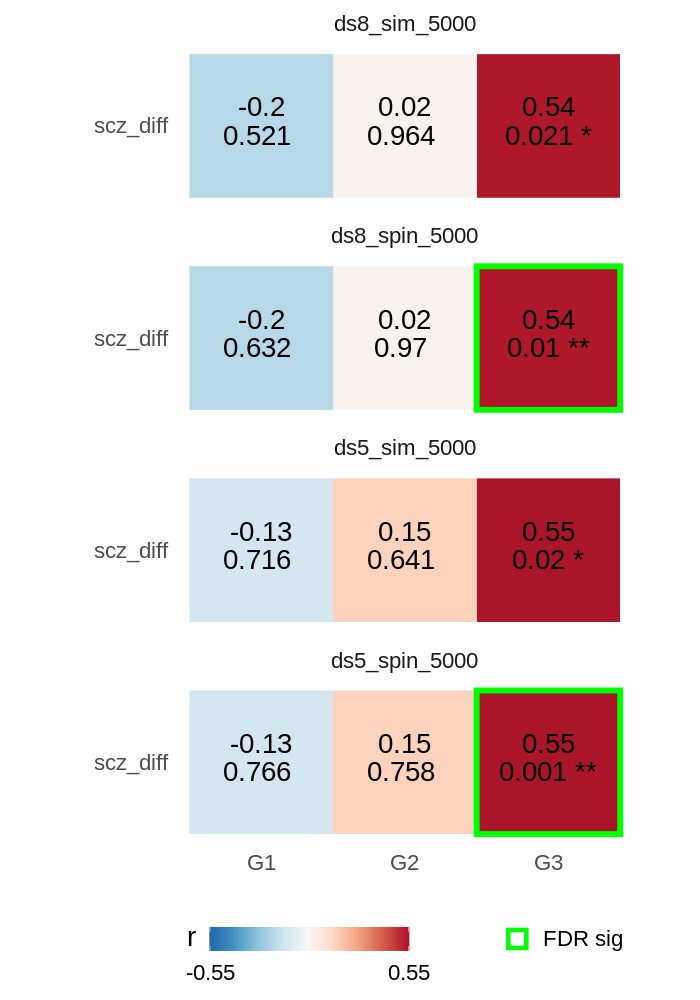

In [16]:
%%R -w 7 -h 10 --units in -r 100 -i corr_versions
source('../code/plot_maps.R')
plot_corr_versions(corr_versions, facet='w', size=7)